In [17]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

import matplotlib.pyplot as plt

In [5]:
def get_gene_info(info):
    if(info == ""):
        return ""
    info_arr = info.split()
    gene_info = info_arr[0]
    if(gene_info[0] == ">"):
        return gene_info[1:]
    else:
        first_slash = gene_info.find('/')
    return gene_info[first_slash + 1:]	

In [6]:
def get_read(f_reads, seek):
    #get info, location, and read
    gene_info = ""
    info = ""
    init_loc = 0
    end_loc = 0
    read = ""
    if(seek == -1):
        seek = f_reads.seek(0,1)
    else:
        seek = f_reads.seek(seek,0)
    info_line = f_reads.readline()
    if(info_line == ""):
        return ""
    #break this into the mates location and everythin
    info_arr = info_line.split("mate")
    #print(info_arr[1])
    first_colon = info_arr[1].find(':')
    location = info_arr[1][first_colon + 1:-1]
    location_arr = location.split('-')
    init_loc = int(location_arr[0])
    end_loc = int(location_arr[1])
    
    f_reads.seek(0,1)
    read = f_reads.readline()

    gene_info = get_gene_info(info_arr[0][1:])

    return (gene_info, init_loc, end_loc, read, seek)

In [15]:
def get_alignment_score(read, transcript_segment):
    alignments = pairwise2.align.localxx(read, transcript_segment)
    scores = []
    for a in alignments:
        al1, al2, score, begin, end = a
        scores = scores + [score]
        #print(format_alignment(*a))
        break
    score = max(scores)
    #print(score)
    return score

In [26]:
def print_transcript_dist(transcript_dist, gene_name):
    axes = plt.gca()
    axes.set_ylim([0, max(transcript_dist) + 1])
    plt.plot(transcript_dist)
    plt.ylabel("read coverage")
    plt.xlabel("transcript location")
    plt.title(gene_name)
    plt.show()
    return

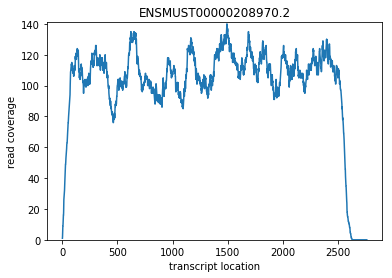

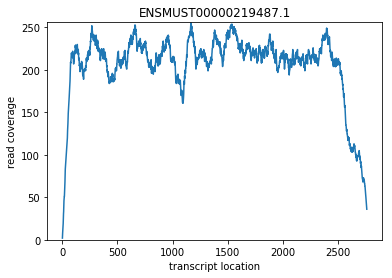

In [27]:

#open file that has the reads
f_reads = open("simulated_mice_2gene2cell/sample_01.fasta")

#open file that we will be writing the information to
f_out = open("scores", "w+")

next_info = ""
gene_scores = {}
seek = -1
breaking = False
#open the file with all the transcripts
with open("mice_tx_sample.fa") as f_transcripts:
    transcript = ""
    for transcript_line in f_transcripts:
        #if you get to a line of information
        if(transcript_line[0] == '>'):
            cur_gene_info = get_gene_info(next_info)
            f_out.write("\n")
            f_out.write(cur_gene_info)
            read_gene_info = cur_gene_info
            next_info = transcript_line
            #padn if there is transcript information available
            #use the transcript information with the current information
            if(transcript != ""):
                transcript = transcript.replace('\n', '')
                #save the read score from each transcript
                transcript_scores = []
                transcript_dist = []
                for i in range(len(transcript)):
                    transcript_dist.append(0)
                    #go through each read for this transcript
                while(cur_gene_info == read_gene_info):
                    read_info = get_read(f_reads, seek)
                    if(read_info == ""):
                        breaking = True
                        break
                    else:
                        read_gene_info, init_loc, end_loc, read, seek = read_info
                        read = read[:-1]
                        transcript_fragment = transcript[init_loc - 1: end_loc]
                    #print()
                    #print(cur_gene_info)
                    #print(read_gene_info)
                    #print(read[:-1])
                    #print(transcript[init_loc - 1: end_loc])
                    #print(init_loc)
                    #print(end_loc)
                    
                    #get the alignment score
                    score = get_alignment_score(read, transcript_fragment)
                    #print(score)
                    transcript_scores = transcript_scores + [score]
                    
                    #add to the dist
                    transcript_dist_fragment = transcript_dist[init_loc - 1: end_loc]
                    transcript_dist_fragment = [x+1 for x in transcript_dist_fragment]
                    transcript_dist = transcript_dist[:init_loc - 1] + transcript_dist_fragment + transcript_dist[end_loc:]

                    if(cur_gene_info == read_gene_info):
                        seek = -1
                        f_out.write("\n")
                        f_out.write(str(score))


                transcript = ""
                gene_scores[cur_gene_info] = transcript_scores[:-1]
                #print the average alignment score for this transcript
                f_out.write('\n')
                f_out.write('average')
                f_out.write(str(float(sum(transcript_scores[:-1])) / max(len(transcript_scores[:-1]), 1)))
                f_out.write('\n')
                
                #print the distribution of this graph
                print_transcript_dist(transcript_dist, cur_gene_info)

                if(breaking):
                    break
        else:
            transcript = transcript + transcript_line


#do the last transcript
cur_gene_info = get_gene_info(next_info)
f_out.write("\n")
f_out.write(cur_gene_info)
read_gene_info = cur_gene_info

if(transcript != ""):
    #go through and look through the other file for the subsequence
    transcript = transcript.replace('\n', '')
    transcript_scores = []
    #while(counter < 2):
    #while we are in the correct reed
    while(cur_gene_info == read_gene_info):
        read_info = get_read(f_reads, seek)
        if(read_info == ""):
            breaking = True
            break
        else:
            read_gene_info, init_loc, end_loc, read, seek = read_info
            read = read[:-1]
            transcript_fragment = transcript[init_loc - 1: end_loc]
        #print()
        #print(cur_gene_info)
        #print(read_gene_info)
        #print(read[:-1])
        #print(transcript[init_loc - 1: end_loc])
        #print(init_loc)
        #print(end_loc)
                    
        #get the alignment score
        score = get_alignment_score(read, transcript_fragment)
        transcript_scores = transcript_scores + [score]
                    
        #add to the dist
        transcript_dist_fragment = transcript_dist[init_loc - 1: end_loc]
        transcript_dist_fragment = [x+1 for x in transcript_dist_fragment]
        transcript_dist = transcript_dist[:init_loc - 1] + transcript_dist_fragment + transcript_dist[end_loc:]

        f_out.write('\n')
        f_out.write(str(score))
        #print(score)
        seek = -1

    transcript = ""
    gene_scores[cur_gene_info] = transcript_scores
    f_out.write('\n')
    f_out.write('average')
    f_out.write(str(float(sum(transcript_scores[:-1])) / max(len(transcript_scores[:-1]), 1)))
    
    print_transcript_dist(transcript_dist, cur_gene_info)
f_out.close()
